지도학습 - 분류 (이진분류, 다중분류)

# 3장 분류

## 주요내용

* 분류 모델 소개
* 분류 모델 성능 평가 방법 소개
* 실전 예제: MNIST 데이터셋을 이용한 숫자 이미지 분류 : 손글씨 데이터

__참고:__ 
핵심 설명과 코드는 &#x1f511;로 표시되었으며 굳이 알아둘 필요가 없는 코드는 &#x270b;로 표시되었다.

## 기본 설정

- 필수 모듈 불러오기
- 그래프 출력 관련 기본 설정 지정

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
    
# 어레이 데이터를 csv 파일로 저장하기
def save_data(fileName, arrayName, header=''):
    np.savetxt(fileName, arrayName, delimiter=',', header=header, comments='')    

# 1부

## 3.1 MNIST (p. 127)

#### 데이터 불러오기

MNIST 데이터셋을 가져온다.
`fetch_openml()` 함수의 반환값은 사전 자료형을 살짝 확장한 `Bunch` 객체이며,
기본적으로 사전 자료형처럼 사용하면 된다.

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

사용되는 키(key)들은 다음과 같다.

In [ ]:
mnist.keys()

`"data"` 속성에 이미지 데이터가, `"target"` 속성에 레이블 데이터가 들어 있다.

In [ ]:
X, y = mnist["data"], mnist["target"]  # target : 숫자가 1인지, 0인지를 나타내는 레이블 값

샘플 수는 70,000개의 이미지이며, 이미지는 길이가 784인 1차원 어레이로 되어 있다.

In [ ]:
X.shape

레이블 또한 70,000개 이며, 0부터 9까지의 숫자이다.

In [ ]:
y.shape

784는 28x28과 같다.
즉, 각 데이터는 원래 28x28 크기의 2차원 어레이를 1차원 어레이로 변환한 값이다. 

In [ ]:
28 * 28

첫째 손글씨 이미지를 확인하면 5로 보이는 이미지가 보인다.

In [ ]:
some_digit = X[0]

# reshape() 함수를 이용하여 28x28 모양의 2차원 어레이로 변환
some_digit_image = some_digit.reshape(28, 28)

# 흑백 이미지로 보여주기
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

첫째 이미지의 실제 레이블 또한 5이다.

In [ ]:
y[0]

그런데 레이블이 문자형으로 저장되어 있기 때문에 모델 훈련을 위해 정수형으로 변환해야 한다.
아래 코드는 8바이트를 사용하여 양의 정수를 표현하는 `uint8` 자료형을 사용한다.

In [ ]:
y = y.astype(np.uint8)  # 정수형으로 변환

이제 모든 레이블이 정수로 변했다.

In [ ]:
y[0]

#### 숫자 이미지 출력 함수

아래 함수는 28x28 모양의 2차원 어레이로 변환하여 숫자 이미지를 보여주는 함수이다.
즉, 앞서 설명한 과정을 함수로 지정하였다.

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

&#x270b; 아래 함수는 여러 개의 숫자 이미지를 한 줄에 10개씩 출력하는 함수이다.
10개의 이미지를 이어붙인 다음에 여러 줄을 다시 이어붙여서 커다란 이미지를 만드는 방식을 사용한다.

In [ ]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

처음 100개의 이미지는 다음과 같다.

In [ ]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

#### 훈련 세트와 테스트 세트로 분류

처음 60,000개의 샘플은 훈련 세트로, 이후 10,000개의 샘플은 테스트 세트로 이미 
계층별 샘플링 방식으로 구분되어 있다.

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련 (p. 130)

이미지가 숫자 5를 표현하는지 여부만을 판단하는 이진 분류기의 훈련을 위해 레이블을 0 또는 1로 변경한다.
* 0: 숫자 5 아님.
* 1: 숫자 5 맞음.

In [ ]:
# 조건식으로 레이블을 바꿔주는 형태

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

확률적 경사 하강법(SGD) 분류기를 훈련시키기 위해 `fit()` 메서드를 호출한다.
* `max_iter=1000`: 훈련 데이터를 최대 1000번 반복해서 학습에 사용함. 
* `tol=le-3`: 전체 훈련 세트를 한 번 학습할 때마다 성능 향상이 연속적으로 지정된 값 이상으로 이루어지지 않을 때 학습을 멈추도록 하는 데에 사용됨. 기본적으로 5번 이상 성능 향상이 10의 -3승 이상 이루어지지 않으면 학습을 강제로 멈춤.

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

# tol : 훈련의 빠르기를 위한 방법

첫째 샘플의 예측값은 `True`, 즉, 숫자 5라고 정확하게 맞춘다.

In [ ]:
sgd_clf.predict([some_digit])  # 예측

## 3.3 성능 측정 (p. 131)

분류기 성능을 측정하는 세 가지 방법을 소개한다.

* 교차 검증을 활용한 정확도 측정
* 정밀도/재현율 조율
* AUC 측정

### 3.3.2 오차 행렬 (p. 133)

교차 검증을 이용하여 평가 점수 대신에 예측을 수행할 수 있다.

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

`confusion_matrix()` 함수가 오차 행렬을 만들어준다.

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)

cm

위 결과는 다음을 보여준다.

```
TN | FP
---|---
FN | TP
```

* TN: 참 음성 개수. 즉, 5가 아닌 이미지를 5가 아니라고 정확하게 예측한 경우의 수
* FP: 거짓 양성 개수. 즉, 5가 아닌 이미지를 5라고 잘못 예측한 경우의 수
* FN: 거짓 음성 개수. 즉, 5를 나타내는 이미지를 5가 아니라고 잘못 예측한 경우의 수
* TP: 참 양성 개수. 즉, 5를 나타내는 이미지를 5라고 정확하게 예측한 경우의 수

__참고:__ 완벽한 이진 분류기의 오차 행렬은 대각선 이외의 값이 모두 0인 대각 행렬이다.

In [ ]:
y_train_perfect_predictions = y_train_5  # 예측값을 실제 레이블로 지정. 즉, 완벽한 분류 결과로 사용
confusion_matrix(y_train_5, y_train_perfect_predictions)

### 3.3.4 정밀도/재현율 트레이드오프 (p. 135)

#### 샘플 점수

SGD 분류기는 `decision_function()`을 이용하여 예측에 필요한 점수를 각 샘플에 대해 계산한다.
예를 들어, 첫째 샘플의 점수는 아래와 같다.

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

예측한 점수가 지정된 임계갓보다 크면 양성, 즉 `True`로 판정한다.
아래 코드는 임곗값을 0으로 지정한 결과를 보여준다.

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
y_some_digit_pred

임곗값을 변경하면 예측값이 달라질 수 있다.
아래 코드는 임곗값을 8000으로 할 때, 첫째 샘플에 대한 예측값이 `False`로 변경되는 것을 보여준다.

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

#### 임곗값 활용

사이킷런에서 임곗값을 임의로 직접 지정할 수는 없다. 
하지만 임곗값을 수동으로 변경하면서 정밀도와 재현율의 관계를 확인한 다음에 
목적에 따라 가장 적절한 임곗값을 찾을 수 있다.

먼저, 교참 검증을 이용하여 모든 훈련 샘플에 대한 예측 점수를 확인한다.

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

`precision_recall_curve()` 함수는 가능한 모든 임곗값에 대한 정밀도와 재현율을 계산한 값을 반환한다.

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

#### 임곗값, 정밀도, 재현율 그래프

임곗값을 기준으로 정밀도와 재현율의 변화를 그래프로 그리면 다음과 같다.
빨강 점들과 연결된 빨강 점선은 정밀도가 90%가 되는 지점의 정밀도와 재현율을 보여준다.

__주의사항:__ 정밀도와 재현율을 담은 어레이의 마지막 항목은 각각 1과 0이며, 이는 기술적인 이유때문에 추가되었다.
따라서 임곗값 어레이의 길이와 맞추기 위해 정밀도와 재현율의 어레이에서 마지막 항목은 무시해야 한다.

In [ ]:
# 정밀도와 재현율 그래프 그리기. x 축은 임곗값을 가리킴.
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2) # 정밀도 어레이 마지막 항목 무시
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)        # 재현율 어레이 마지막 항목 무시
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                             
    plt.axis([-50000, 50000, 0, 1])            

# 정밀도 90%가 달성되는 지점에서의 재현율과 임곗값
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# 빨강 점과 빨강 점선 그리기
plt.figure(figsize=(8, 4))                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")  # 수직 빨강 점선
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                 # 위 수평 빨강 점선
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")  # 아래 수평 빨강 점선
plt.plot([threshold_90_precision], [0.9], "ro")                              # 위 빨강 점 
plt.plot([threshold_90_precision], [recall_90_precision], "ro")              # 아래 빨강 점

save_fig("precision_recall_vs_threshold_plot")                                
plt.show()

재현율 그래프와는 달리 정밀도 그래프는 100% 근처에서 상승과 하강이 살짝 이루지도 한다. 
이유는 임곗값을 올리면서 양성으로 판명된 샘플의 수는 기본적으로 줄어들지만 거짓 양성 샘플 수는 
순간적으로는 변하지 않을 수도 있기 때문이다. 
반면에 재현율은 전체 양성 샘플 수를 대상으로 하기에 그래프의 진동이 발생하지 않는다.

#### 사이킷런 분류기의 임곗값

SGD 분류기는 0을 임곗값으로 사용하며,
이를 아래와 같이 확인할 수 있다.

__참고:__ `all()` 메서드는 모든 항목이 참일 때만 참을 반환한다.

In [ ]:
(y_train_pred == (y_scores > 0)).all()

#### 정밀도와 재현율 사이의 관계

아래 코드는 재현율과 정밀도 사이의 관계를 직접적으로 보여준다.
빨강 점과 빨강 선은 앞 도표에서처럼 정밀도 90%가 달성되는 지점의 재현율을 보여주는 용도이다.

In [ ]:
# 정밀도와 재현율 사이의 관계 그래프 그리기
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

# 빨강 점과 빨강 점선 그리기
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:") # 수직 빨강 점선
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")                # 수평 빨강 직선
plt.plot([recall_90_precision], [0.9], "ro") # 빨강 점 좌표
save_fig("precision_vs_recall_plot")
plt.show()

#### 정밀도/재현율 조율 모델 생성

아래 코드는 정밀도 90%가 달성되는 지점의 임곗값을 확인한다.

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [ ]:
threshold_90_precision

실제로 바로 위에서 구해진 임곗값을 사용하면 정밀도가 90%인 모델을 (수동)얻게 된다.

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

하지만 그렇게 얻어진 모델의 재현율은 47.9% 정도로 떨어지기에 사용 목적에 적절한 모델인지 판단해야 한다.

In [ ]:
recall_score(y_train_5, y_train_pred_90)

### 3.3.5 ROC 곡선 (p. 141)

__수신기 조작 특성__(ROC)을 그려서 분류기의 성능을 측정할 수 있다.
여기서 사용되는 기준은 재현율과 정밀도의 관계가 아니라
__참 양성 비율__(true positive rate, TPR)과 
__거짓 양성 비율__(false positive rate, FPR) 사이의 관계이다. 

TPR은 재현율의 다른 명칭이며, FPR은 실제로 음성에 속하는 샘플 중에서 양성으로 잘못 판정되는 경우의 비율이다. 

```
TN | FP
---|---
FN | TP
```

$$
\text{TPR} = \frac{\text{TP}}{\text{FN} + \text{TP}} \qquad
\text{FPR} = \frac{\text{FP}}{\text{TN} + \text{FP}}
$$

앞서 정밀도와 재현율의 관계를 그래프로 묘사한 것과 비슷한 방식으로
TPR와 FPR 사이의 관계를 그래프로 그리면 다음과 같다.

* `roc_curve()` 함수: 임곗값의 변화에 따른 TPR, FPR 계산. 
    `precision_recall_curve()` 함수와 유사한 기능 제공.

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
# SGD 분류기 모델의 TPR과 FPR 사이의 관계 그래프 그리기
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)

# 정밀도가 90%를 넘어설 때의 재현율(TPR, 참 양성 비율)에 해당하는 거짓 양성 비율(FPR)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]   # 0.0053 정도         
# 빨강 점과 원점 사이의 실선 그리기
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # 수직 빨강 점선. 좌표는 (0.0053, 0.48) 정도
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # y축과 빨강 점 사이의 수평 빨강 점선(거의 안보임))
plt.plot([fpr_90], [recall_90_precision], "ro")               # 빨강 점
save_fig("roc_curve_plot")                                  
plt.show()

TPR이 증가하면 FPR도 증가한다. 
따라서 거짓 양성 비율을 최대한 낮추면서 재현율을 최대한 높일 수 있는 모델이 좋은 모델이다.
이를 계량화 화면, ROC 곡선의 아랫쪽의 면적인 __AUC__(area under curve)가 1에 가깝게 
나오도록 해주는 모델이 좋은 모델이다. 

SGD 분류기의 AUC는 0.96 정도이다.

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

#### 랜덤 포레스트 분류기

랜덤 포레스트 분류기 모델을 이용해보자.

__주의사항:__ `RandomForestClassifier` 모델은 점수를 예측하는 `predict_function()` 메서드가 없다.
대신에 확률을 예측하는 `predict_proba()` 메서드를 교차 검증 예측에 사용할 수 있다. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

`y_probas_forest` 변수는 각 훈련 샘플에 대한 음성 클래스, 양성 클래스에 속할 확률을 포함한 2차원 어레이를 
가리킨다.

In [ ]:
y_probas_forest

모든 샘플에 대한 양성 클래스에 속할 확률만 가져와서 ROC 곡선을 그려보자.
즉, 양성 클래스에 속할 확률을 임곗점으로 활용하여 TPR과 FPR의 관계를 그래프로 나타낸다.

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

램덤 포레스트 분류기의 ROC 곡선이 보다 1x1 크기의 직사각형에 가까워졌다.

In [ ]:
# 램덤 포레스트 분류기의 ROC 곡선 그리기
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]  # 90% FPR에 대응하는 TPR. 약 0.95

plt.figure(figsize=(8, 6))

# 파랑 점 곡선: SGD 분류기의 ROC 곡선
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
# 파랑 실선: 랜덤 포레스트 분류기의 ROC 곡선
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")      # 짧은 빵강 수직 점선
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # 아랫쪽 빨강 수평 점선 (거의 안보임)
plt.plot([fpr_90], [recall_90_precision], "ro")                  # 아래쪽 빨강 점. 좌표는 (0.0053, 0.48) 정도
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")        # 윗쪽 빨강 수평 점선 (거의 안보임)
plt.plot([fpr_90], [recall_for_forest], "ro")                    # 위쪽 빨강 점. 좌표는 (0.0053, 0.95) 정도
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

AUC 값도 SGD 분류기보다 훨씬 좋아졌음을 확인할 수 있다.

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

#### 랜덤 포레스트 분류기의 정밀도와 재현율

교차 검증을 이용한 모델의 정밀도는 99%, 재현율은 86.6% 정도로 나쁘지 않은 편이다.

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

# 2부

## 3. 4 다중 클래스 분류 (p. 145)

이제부터 두 개 보다 많은 클래스로 분류하는 다중 클래스 분류를 진행한다.

#### 서포트 벡터 머신 활용

서포트 벡터 머신(SVC, support vector machine)은 기본적으로 이진 분류기이지만
__일대일__(one-versus-one) 전략을 활용하여 다중 클래스 분류에도 사용된다.

* `gamma="auto"`: 이 하이퍼파라미터의 역할은 5장에서 자세히 설명한다. 
    다만, 사이킷런 버전 0.22부터 `gamma`의 기본값이 `"auto"`에서 `"scale"` 로 변경되어
    여기서는 명시적으로 키워드 인자를 지정한다.

__주의사항:__ 서포트 벡터 머신 분류기는 훈련 세트의 크기에 민감하다. 따라서
아래 코드는 훈련 세트의 크기를 1,000으로 줄여서 훈련하는 것을 보여준다.
6만 개의 훈련 세트 전체를 대상으로 하면 시간이 좀 걸릴 것이다.

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # 이제부터는 y_train_5 대신에 y_train 사용

SVC(gamma='auto', random_state=42)

첫째 훈련 샘플에 대해 숫자 5로 정확하게 예측한다.

In [ ]:
svm_clf.predict([some_digit])

`decision_function()` 메서드는 샘플이 각각의 클래스에 대한 점수를 어레이로 반환한다.
예를 들어 첫째 훈련 샘플에 대한 각 클래스별 점수는 다음과 같다.

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

# 0일 확률, 1일 확률, 2일 확률 , ... , 9일 확률

5번 인덱스의 값이 가장 크다.

__참고:__ 넘파이의 `argmax()` 함수는 최댓값이 위치한 인덱스를 반환한다.

In [ ]:
np.argmax(some_digit_scores)

# 가장 큰 인덱스값

5번 인덱스에 해당하는 클래스를 알아보기 위해 사용된 클래스를 확인하면 다음과 같다.

In [ ]:
svm_clf.classes_

5번 인덱스에 해당하는 클래스는 (우연히도) 숫자 5이다.

__주의사항:__ 분류 클래스가 여기서는 0, 1, 2, ..., 9 이기에 5번 인덱스, 즉 6번째 클래스는 5이다. 
하지만 이것은 우연에 불과하다. 예를 들어, 만약에 클래스가 1, 2, 3, ..., 9, 0 으로 순서로 
사용된다면 5번 인덱스에 해당하는 클래스는 6이 된다.

In [ ]:
svm_clf.classes_[5]

#### 일대다 방식 활용

서포트 벡터 머신 분류기는 기본적으로 일대일(OvO) 방식으로 다항 클래스 분률를 진행한다.
하지만 일대다(OvR) 방식을 사용하려면 `OneVsRestClassfier` 가 SVC 모델을 상속하도록 하면 된다.

__주의사항:__ 서포트 벡터 머신 분류기는 훈련 세트의 크기에 민감하며, 이런 이유로 적은 수의 훈련 세트에 
대해 많은 많은 수의 이진 분류를 진행하는 일대일 방식을 기본으로 사용한다. 
아래 코드는 훈련 세트의 크기를 1,000으로 줄여서 일대다 방식을 SVC 모델에 적용한다.
만약에 6만개의 훈련 세트에 대해 아래 코드를 실행하면 꽤 오래 걸릴 것이다. 

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])   # 첫 1000개의 훈련 샘플만을 이용한 일대다 방식 진행

첫째 샘플을 5라고 예측한다.

In [ ]:
ovr_clf.predict([some_digit])

아래 코드는 일대다 방식에 사용된 SVC 모델의 수가 10개임을 확인해준다.

* `estimators_` 메서드: 일대다 방식에 사용된 예측기, 여기서는 SVC 모델을 저장한다.

In [ ]:
len(ovr_clf.estimators_)

#### `SGDClassifier`와 `RandomForestClassifier` 분류기

두 모델은 다중 클래스 분류를 기본으로 지원하기에 일대일, 일대다 방식을 고민할 필요가 없다.
아래 코드는 SGD 분류기를 이용하여 10개 클래스 전체를 대상으로 분류를 진행한다.
(실행에 몇 분 걸린다.)

In [ ]:
sgd_clf.fit(X_train, y_train)

KeyboardInterrupt: ignored

__주의사항:__ 책에서와는 달리 첫째 샘플이 5가 아니라고 예측할 수도 있다. 여기서는 3으로 예측한다.

In [ ]:
sgd_clf.predict([some_digit])

실제로 3과 혼동할만 하다.

In [ ]:
plot_digit(some_digit)

첫째 샘플에 대한 10개 클래스별 예측 점수는 다음과 같이 3번 인덱스에 위치한 값이 가장 크다.

In [ ]:
sgd_clf.decision_function([some_digit])

아래 코드는 3-겹 교차 검증을 이용하여 SGD 모델의 성능을 정확도를 기준으로 측정한다.
이진 분류의 경우와는 달리 여기서는 정확도를 충분히 신뢰할 수 있다.
이유는 각 숫자의 비율이 비슷하기 때문이다.

**경고**: 사용하는 하드웨어에 따라 다음 두 셀을 실행하는데 30분 또는 그 이상 걸릴 수 있다.

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

성능 결과는 87% 정도의 정확도이다. 임의로 찍는 랜덤 분류기가 10% 정도의 정확도를 가질 것이기에
이진 분류의 경우와 달리 상대적으로 매우 높은 성능의 다중 클래스 분류기라 할 수 있다.
하지만 예를 들어 2장에서 전처리 단계로 사용한 축척 조정(스케일링)만 적용하더라도 성능을 90%정도로
좀 더 끌어올릴 수 있다.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

# 항상 한다고 생각하면 될 것.

## 3.6 다중 레이블 분류 (p. 152)

다중 레이블 분류는 하나의 샘플에 대해 한 개의 클래스가 아닌 여러 개의 클래스를 예측하는 분류이다.
예를 들어, 하나의 사진에 지정된 세 사람의 인물이 포함되어 있는지 여부를 예측하고 길이가 3인 어레이로 반환하라고 할 수 있다.
지정된 세 사람이 앨리스, 밥, 찰리이면 다중 레이블 분류기는 아래와 같은 예측값을 반환해야 한다.

```python
[True, False, True]
```

위 결과에 따르면 앨리스와 찰리는 사진에 있지만 밥은 사진에 없다고 예측된다.

아래 코드는 MNIST 이미지 샘플 각각에 대해 이미지가 가리키는 숫자를 예측하는 것 대신에
이미지가 나타내는 수가 홀수인지 여부와, 7보다 같거나 큰지 여부를 함께 예측한다.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

#### 다중 레이블 분류기 평가

* 다중 레이블 분류기를 평가하는 방법은 모델과 목적에 따라 달라짐.
    

* 예를들어, 각 레이블의 F<sub>1</sub> 점수를 구하고 레이블에 대한 가중치를 적용한 
    평균 점수 계산
    * 가중치 예제: 타깃 레이블에 속한 샘플 수인 __지지도__(support).
        즉, 샘플 수가 많은 클래스의 가중치를 보다 크게 줄 수 있음.

아래 코드는 모든 레이블의 중요도가 동일하다고 가정하면서 위 KNN 모델의 F<sub>1</sub> 점수를 계산한다.

**경고**: 다음 셀은 실행하는데 매우 오래 걸린다(하드웨어에 따라 몇 시간이 걸릴 수 있다).

In [ ]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# 연습문제 


## 1. 97% 정확도의 MNIST 분류기

**경고**: 사용하는 하드웨어에 따라 다음 셀을 실행하는데 16시간 또는 그 이상 걸릴 수 있습니다.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  32.8s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  33.2s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  32.6s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  32.5s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  39.8s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  32.1s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  32.2s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  32.7s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  32.3s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  33.4s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  36.3s
[CV 2/5] END ....n_neighbors=4, weights=uniform;, score=0.968 total time=  36.4s
[CV 3/5] END ....n_neighbors

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [ ]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [ ]:
grid_search.best_score_

0.9716166666666666

In [ ]:

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## 3. 타이타닉 데이터셋 도전

승객의 나이, 성별, 승객 등급, 승선 위치 같은 속성을 기반으로 하여 승객의 생존 여부를 예측하는 것이 목표입니다.

먼저 [캐글](https://www.kaggle.com)에 로그인 하고 [타이타닉 챌린지](https://www.kaggle.com/c/titanic)에서 `train.csv`와 `test.csv`를 다운로드합니다. 두 파일을 `datasets/titanic` 디렉토리에 저장하세요(번역서 깃허브에는 두 파일이 이미 포함되어 있습니다).

그다음 데이터를 적재합니다:

In [ ]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [ ]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/비교과/빅파이/화요일 스터디/1주차_타이타닉 실습/data/train.csv")
test_data = load_titanic_data("/content/drive/MyDrive/비교과/빅파이/화요일 스터디/1주차_타이타닉 실습/data/test.csv")

데이터는 이미 훈련 세트와 테스트 세트로 분리되어 있습니다. 그러나 테스트 데이터는 레이블을 가지고 있지 않습니다: 훈련 데이터를 이용하여 가능한 최고의 모델을 만들고 테스트 데이터에 대한 예측을 캐글(Kaggle)에 업로드하여 최종 점수를 확인하는 것이 목표입니다.

훈련 세트에서 맨 위 몇 개의 열을 살펴 보겠습니다:

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


속성은 다음과 같은 의미를 가집니다:
* **Survived**: 타깃입니다. 0은 생존하지 못한 것이고 1은 생존을 의미합니다.
* **Pclass**: 승객 등급. 1, 2, 3등석.
* **Name**, **Sex**, **Age**: 이름 그대로 의미입니다.
* **SibSp**: 함께 탑승한 형제, 배우자의 수.
* **Parch**: 함께 탑승한 자녀, 부모의 수.
* **Ticket**: 티켓 아이디
* **Fare**: 티켓 요금 (파운드)
* **Cabin**: 객실 번호
* **Embarked**: 승객이 탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southampton)

누락된 데이터가 얼마나 되는지 알아보겠습니다:

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


괜찮네요. **Age**, **Cabin**, **Embarked** 속성의 일부가 null입니다(891개의 non-null 보다 작습니다). 특히 **Cabin**은 77%가 null입니다. 일단 **Cabin**은 무시하고 나머지를 활용하겠습니다. **Age**는 19%가 null이므로 이를 어떻게 처리할지 결정해야 합니다. null을 중간 나이로 바꾸는 것이 괜찮아 보입니다.

**Name**과 **Ticket** 속성도 값을 가지고 있지만 머신러닝 모델이 사용할 수 있는 숫자로 변환하는 것이 조금 까다롭습니다. 그래서 지금은 이 두 속성을 무시하겠습니다.

통계치를 살펴 보겠습니다:

In [ ]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* 이크, 38%만 **Survived**입니다. :( 거의 40%에 가까우므로 정확도를 사용해 모델을 평가해도 괜찮을 것 같습니다.
* 평균 **Fare**는 32.20 파운드라 그렇게 비싸보이지는 않습니다(아마 요금을 많이 반환해 주었기 때문일 것입니다)
* 평균 **Age**는 30보다 작습니다.

타깃이 0과 1로 이루어졌는지 확인합니다:

In [ ]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

범주형 특성들을 확인해 보겠습니다:

In [ ]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [ ]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [ ]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

**Embarked** 특성은 승객이 탑승한 곳을 알려 줍니다: C=Cherbourg, Q=Queenstown, S=Southampton.

**노트**: 아래 코드는 `Pipeline`, `FeatureUnion`와 사용자 정의 `DataFrameSelector` 클래스를 사용해 각 열을 다르게 전처리합니다. 사이킷런 0.20부터는 이전 장에서처럼 `ColumnTransformer`를 사용하는 것이 좋습니다.

전처리 파이프라인을 만들어 보죠. 이전 장에서 만든 `DataframeSelector`를 재사용하여 `DataFrame`에서 특정 열을 선택하겠습니다:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

숫자 특성을 위한 파이프라인을 만듭니다:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [ ]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

문자열로된 범주형 열을 위해 별도의 Imputer 클래스가 필요합니다(일반 `SimpleImputer` 클래스는 이를 처리하지 못합니다):

In [ ]:
# stackoverflow.com/questions/25239958 에서 착안했습니다
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

이제 범주형 특성을 위한 파이프라인을 만듭니다:

In [ ]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [ ]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

마지막으로 숫자와 범주형 파이프라인을 연결합니다:

In [ ]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

좋습니다! 이제 원본 데이터를 받아 머신러닝 모델에 주입할 숫자 입력 특성을 출력하는 전처리 파이프라인을 만들었습니다.

In [ ]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

레이블을 가져옵니다:

In [ ]:
y_train = train_data["Survived"]

이제 분류기를 훈련시킬 차례입니다. 먼저 `SVC`를 사용해 보겠습니다:

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

모델이 잘 훈련된 것 같습니다. 이를 사용해서 테스트 세트에 대한 예측을 만듭니다:

In [ ]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

이 예측 결과를 (캐글에서 기대하는 형태인) CSV 파일로 만들어 업로드하고 평가를 받아볼 수 있습니다. 하지만 그냥 좋을거라 기대하는 것보다 교차 검증으로 모델이 얼마나 좋은지 평가하는 것이 좋습니다.

In [ ]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

정확도가 73% 이상입니다. 확실히 무작위로 선택한 것보다는 좋습니다. 하지만 아주 높은 점수는 아닙니다. 캐글에서 타이타닉 경연 대회의 [리더보드](https://www.kaggle.com/c/titanic/leaderboard)를 보면 상위 10%내에 들려면 80% 이상의 정확도를 내야합니다. 어떤 사람들은 100%를 달성했습니다. 하지만 타이타닉의 [희생자 목록](https://www.encyclopedia-titanica.org/titanic-victims/)을 쉽게 찾을 수 있으므로 머신러닝을 사용하지 않고도 이런 정확도를 달성할 수 있습니다! ;-) 우리는 80% 정도의 정확도를 내는 모델을 만들어 보겠습니다.

`RandomForestClassifier`를 적용해 보겠습니다:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

훨씬 좋네요!

10 폴드 교차 검증에 대한 평균 정확도를 보는 대신 모델에서 얻은 10개의 점수를 1사분위, 3사분위를 명료하게 표현해주는 상자 수염 그림(box-and-whisker) 그래프를 만들어 보겠습니다(이 방식을 제안해 준 Nevin Yilmaz에게 감사합니다). `boxplot()` 함수는 이상치(플라이어(flier)라고 부릅니다)를 감지하고 수염 부분에 이를 포함시키지 않습니다. 1사분위가 $Q_1$이고 3사분위가 $Q_3$이라면 사분위수 범위는 $IQR = Q_3 - Q_1$가 됩니다(이 값이 박스의 높이가 됩니다). $Q_1 - 1.5 \times IQR$ 보다 낮거나 $Q3 + 1.5 \times IQR$ 보다 높은 점수는 이상치로 간주됩니다.

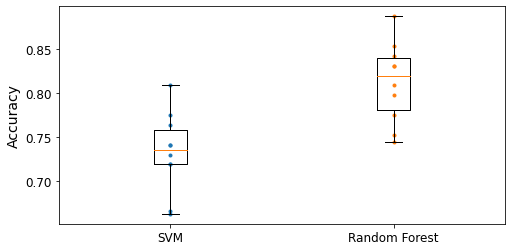

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

이 결과를 더 향상시키려면:
* 교차 검증과 그리드 탐색을 사용하여 더 많은 모델을 비교하고 하이퍼파라미터를 튜닝하세요.
* 특성 공학을 더 시도해 보세요, 예를 들면:
  * **SibSp**와 **Parch**을 이 두 특성의 합으로 바꿉니다.
  * **Survived** 특성과 관련된 이름을 구별해 보세요(가령, 이름에 "Countess"가 있는 경우 생존할 가능성이 높습니다).
* 수치 특성을 범주형 특성으로 바꾸어 보세요: 예를 들어, 나이대가 다른 경우 다른 생존 비율을 가질 수 있습니다(아래 참조). 그러므로 나이 구간을 범주로 만들어 나이 대신 사용하는 것이 도움이 될 수 있스니다. 비슷하게 생존자의 30%가 혼자 여행하는 사람이기 때문에 이들을 위한 특별한 범주를 만드는 것이 도움이 될 수 있습니다(아래 참조).

In [ ]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [ ]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000
